# Population by commune

In [1]:
from pynsee.geodata import get_geodata_list, get_geodata

import math
import pandas as pd
from pandas.api.types import CategoricalDtype
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import descartes

In [2]:
import logging
import sys
logging.basicConfig(stream=sys.stdout,
                    level=logging.INFO, 
                    format="%(message)s")

In [2]:
# get geographical data list
geodata_list = get_geodata_list()
# get departments geographical limits
com = get_geodata('ADMINEXPRESS-COG-CARTO.LATEST:commune').to_crs("EPSG:3035")

In [3]:
com["area"] = com['geometry'].area / 10**6
mapcom = com.to_crs(epsg=3857)

mapcom['REF_AREA'] = 'D' + mapcom['insee_dep']
mapcom['density'] = mapcom['population'] / mapcom['area'] 

In [4]:
mapcom = mapcom.transform_overseas(
    departement=['971', '972', '974', '973', '976'],  factor=[1.5, 1.5, 1.5, 0.35, 1.5])

In [5]:
mapcom = mapcom.zoom(departement = ["75","92", "93", "91", "77", "78", "95", "94"],
                     factor=1.5, startAngle = math.pi * (1 - 3 * 1/9))

In [6]:
mapcom.loc[mapcom.density < 40, 'range'] = "< 40"
mapcom.loc[mapcom.density >= 20000, 'range'] = "> 20 000"

density_ranges = [40, 80, 100, 120, 150, 200, 250, 400, 600, 1000, 2000, 5000, 10000, 20000]
list_ranges = []
list_ranges.append( "< 40")

for i in range(len(density_ranges)-1):
    min_range = density_ranges[i]
    max_range = density_ranges[i+1]
    range_string = "[{}, {}[".format(min_range, max_range)
    mapcom.loc[(mapcom.density >= min_range) & (mapcom.density < max_range), 'range'] = range_string
    list_ranges.append(range_string)

list_ranges.append("> 20 000")

mapcom['range'] = mapcom['range'].astype(CategoricalDtype(categories=list_ranges, ordered=True))  

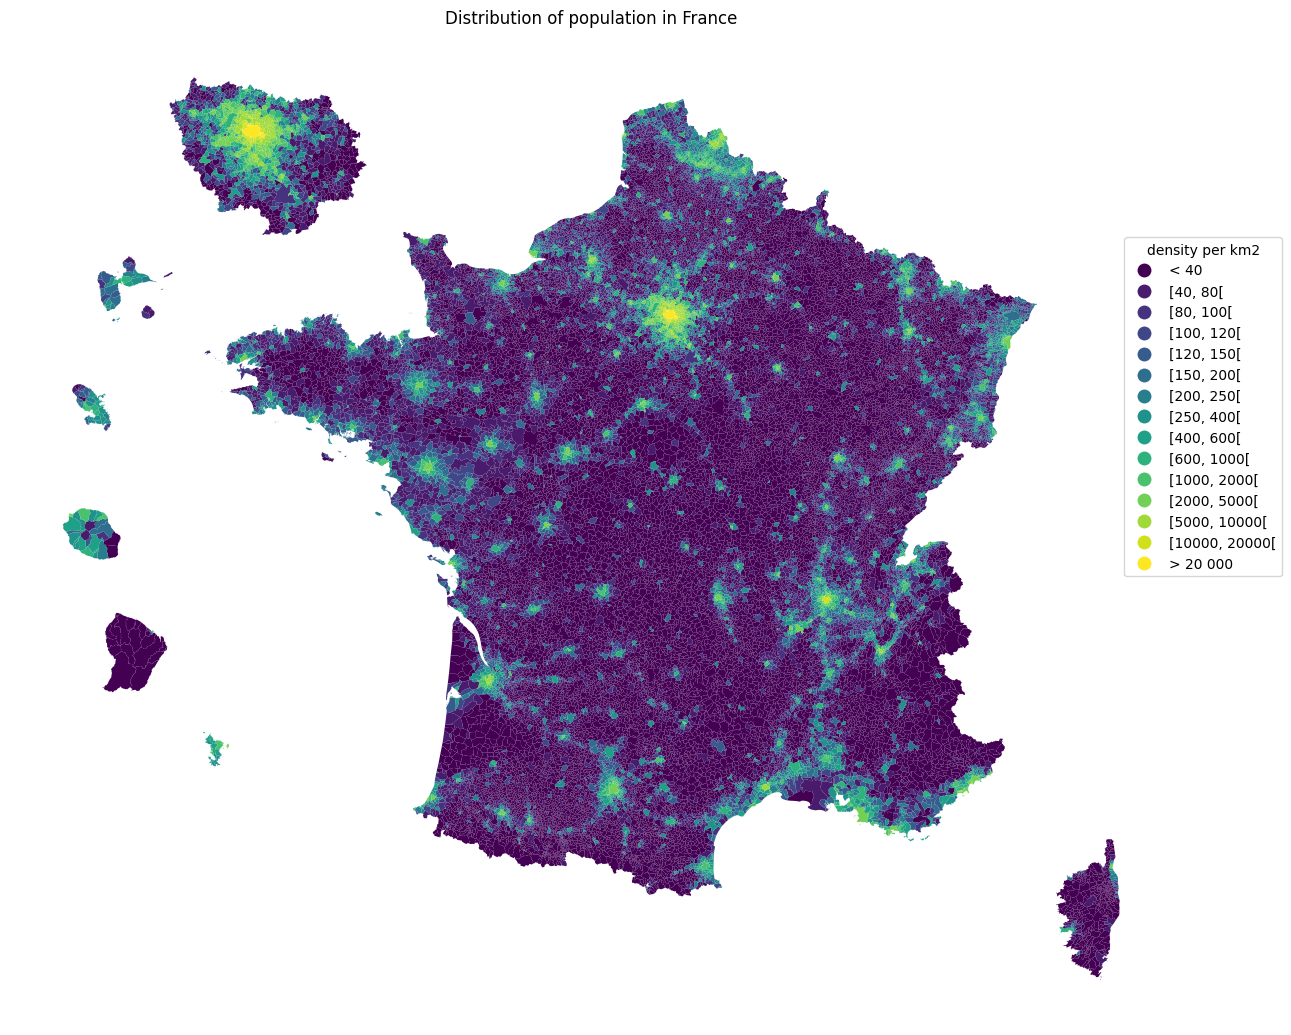

In [7]:
fig, ax = plt.subplots(1,1,figsize=[15,15])
mapcom.plot(column='range', cmap=cm.viridis,
    legend=True, ax=ax,
    legend_kwds={'bbox_to_anchor': (1.1, 0.8),
                 'title':'density per km2'})
ax.set_axis_off()
ax.set(title='Distribution of population in France')
plt.show()

fig.savefig('pop_france.svg',
            format='svg', dpi=1200,
            bbox_inches = 'tight',
            pad_inches = 0)